# CartPole (倒立振子)

- [openAI gym::CartPole v0](https://github.com/openai/gym/wiki/CartPole-v0)
- 以下の説明は[vmayoral:basic_reinforcement_learning/tutorial4/README.md](https://github.com/vmayoral/basic_reinforcement_learning/blob/master/tutorial4/README.md)を参考資料として作成したものです。

## Random action

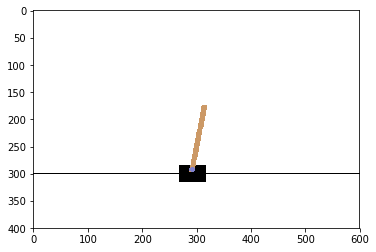

Episode 3 finished after 25 timesteps


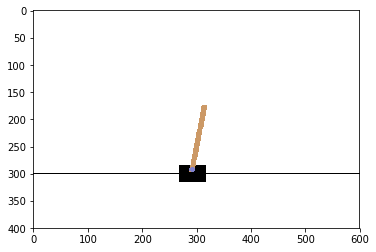

In [41]:
import gym
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

env = gym.make('CartPole-v0')

for n_episode in range (3):
    observation = env.reset()
    for t in range(100):
        plt.imshow(env.render(mode='rgb_array'))
        display.clear_output(wait=True)
        display.display(plt.gcf())

        action = env.action_space.sample()
        observation, reward, done, info = env.step(action)
        if done:
            print("Episode {} finished after {} timesteps".format(n_episode+1,t+1))
            break

## 概要

[OpenAI Gym CartPole-v0](https://github.com/openai/gym/wiki/CartPole-v0)を参照

## action, state空間の確認

In [71]:
import gym
env = gym.make('CartPole-v0')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [72]:
print(env.observation_space)

Box(4,)


In [73]:
print(env.observation_space.low)

[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]


In [74]:
print(env.action_space)

Discrete(2)


In [75]:
print(env.observation_space.high)

[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]


In [80]:
obs=env.reset()
print(obs)

[ 0.03119355 -0.02297458  0.04771061 -0.02131496]
0.031193554348091262 -0.022974578031664986 0.04771061212172649 -0.0213149635534586


In [81]:
cart_pos, pole_ang, cart_vel, pole_angvel=obs  # obsの各要素を， 別々の変数に代入する
print(cart_pos, pole_ang, cart_vel, pole_angvel)

0.031193554348091262 -0.022974578031664986 0.04771061212172649 -0.0213149635534586


## 問題点
- 問題点: 状態空間が連続値をとる。
- 対策: 連続値のまま扱う方法もあるが，今回は，状態空間を離散値に分割する。いくつの状態空間に分割するべきかは考慮すべき点。

**[質問]** 状態空間を多数の離散値に分割することのメリットとデメリットを説明しなさい。

In [108]:
# 状態の各要素をそれぞれ離散化
import numpy as np

n_bins=10 # n_bins-2個の閉区間 + 両端の2個
bins = np.linspace(start=-2.0, stop=2.0, num=n_bins-1) # [start,stop]をnbins個の点で区切る(閉区間はnbins-1個)

def to_bin(value, bins):
    return np.digitize(x=[value], bins=bins)[0]

[numpy.linspace(start,stop,num)](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.cut.html)
    - `start`, `stop`: スカラー
    - `num`: 生成するサンプル数
[numpy.digitize(x,bins)](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.digitize.html)
    - `x`: 1次元配列
    - `bins`: binsの配列
    - 返り値: `bins[i-1] <= x < bins[i]`を満たすi (i=1,...,len(bins)-1)を返す。binsの範囲を超えたら，その値に応じて0か最大値(`len(bins)`)のベクトル(ndarray)を返す

- **[質問]** 上記のように状態の各要素をそれぞれ10個の離散値にした場合，とりうる状態数は全部でいくつになりますか?
- **[質問]** 1エピソードが平均10ステップとすると，全ての状態に対する学習を1回づつ行うには最低何回のエピソードが必要ですか?

In [119]:
bins=np.linspace(start=-2.0, stop=2.0, num=9)
print(bins)
print(len(bins))
print(np.digitize(x=[-1.9],bins=bins))
print(np.digitize(x=[-2.1],bins=bins)[0])
print(np.digitize(x=[1.9],bins=bins)[0])
print(np.digitize(x=[2.1],bins=bins)[0])

[-2.  -1.5 -1.  -0.5  0.   0.5  1.   1.5  2. ]
9
[1]
0
8
9


## Q学習

In [122]:
class QLearn:
    def __init__(self, actions, epsilon, alpha, gamma):
        self.q = {}
        self.epsilon = epsilon  # exploration constant
        self.alpha = alpha      # discount constant
        self.gamma = gamma      # discount factor
        self.actions = actions

    def getQ(self, state, action):
        return self.q.get((state, action), 0.0)

    def learnQ(self, state, action, reward, maxqnew):
        '''
        Q-learning:
            Q(s, a) += alpha * (reward + max(Q(s')) - Q(s,a))            
        '''
        oldq = self.q.get((state, action), None)
        if oldq is None:
            self.q[(state, action)] = reward
        else:
            self.q[(state, action)] = oldq + self.alpha * (reward + self.gamma*maxqnew - oldq)

    def chooseAction(self, state, return_q=False):
        q = [self.getQ(state, a) for a in self.actions]
        maxQ = max(q)

        if random.random() < self.epsilon:
            minQ = min(q); mag = max(abs(minQ), abs(maxQ))
            # add random values to all the actions, recalculate maxQ
            q = [q[i] + random.random() * mag - .5 * mag for i in range(len(self.actions))] 
            maxQ = max(q)

        count = q.count(maxQ)
        # 最大値をとるactionが複数あるときは，random選択
        if count > 1:
            best = [i for i in range(len(self.actions)) if q[i] == maxQ]
            i = random.choice(best)
        else:
            i = q.index(maxQ)

        action = self.actions[i]        
        if return_q: # Q値も返す場合
            return action, q
        return action

    def learn(self, state1, action1, reward, state2):
        maxqnew = max([self.getQ(state2, a) for a in self.actions])
        self.learnQ(state1, action1, reward, maxqnew)

**[問題]** cartpoleを学習プログラムを作りなさい。状態の離散化は以下で行える。ただし，状態分割を行う区間は各自検討すること。
- 報酬の設定方法次第で学習効率はいろいろ変わる。例えば，エピソード終了時(タスク失敗時)の報酬は-20とすると，どのように学習速度は変わるだろうか。
- さらに，学習を早くするにはどのような工夫をできるだろうか。報酬設定だけではなく，いろいろな可能性を考えて検証しなさい。

```
N_BINS=10
cart_pos_bins = np.linspace(start=-2.0, stop=2.0, num=N_BINS-1)
pole_ang_bins = np.linspace(start=-1.6, stop=1.6, num=N_BINS-1)
cart_vel_bins = np.linspace(start=-1.8, stop=1.8, num=N_BINS-1)
pole_angvel_bins = np.linspace(start=-2.8, stop=2.8, num=N_BINS-1)

def build_state(features):
    return int("".join(map(lambda feature: str(int(feature)), features)))

def to_bin(value, bins):
    return np.digitize(x=[value], bins=bins)[0]
...

obs = env.reset()
cart_pos, pole_ang, cart_vel, pole_angvel = obs
state = build_state([to_bin(cart_pos, cart_pos_bins),
                     to_bin(pole_ang, pole_ang_bins),
                     to_bin(cart_vel, cart_vel_bins),
                     to_bin(pole_angvel, pole_angvel_bins)])  
```

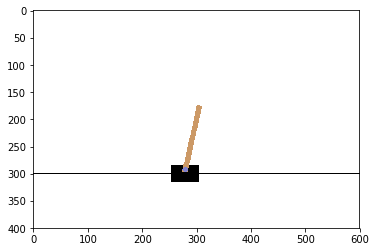

Episode 1 finished after 15 timesteps
Episode 2 finished after 15 timesteps
Episode 3 finished after 11 timesteps
Episode 4 finished after 27 timesteps
Episode 5 finished after 25 timesteps
Episode 6 finished after 18 timesteps
Episode 7 finished after 17 timesteps
Episode 8 finished after 17 timesteps
Episode 9 finished after 37 timesteps
Episode 10 finished after 9 timesteps
Episode 11 finished after 95 timesteps
Episode 12 finished after 53 timesteps
Episode 13 finished after 29 timesteps
Episode 14 finished after 89 timesteps
Episode 15 finished after 67 timesteps
Episode 16 finished after 94 timesteps
Episode 17 finished after 45 timesteps
Episode 18 finished after 93 timesteps
Episode 19 finished after 46 timesteps
Episode 20 finished after 25 timesteps
Episode 21 finished after 175 timesteps
Episode 22 finished after 124 timesteps
Episode 23 finished after 82 timesteps
Episode 24 finished after 126 timesteps
Episode 25 finished after 47 timesteps
Episode 26 finished after 200 ti

Episode 217 finished after 200 timesteps
Episode 218 finished after 158 timesteps
Episode 219 finished after 200 timesteps
Episode 220 finished after 200 timesteps
Episode 221 finished after 200 timesteps
Episode 222 finished after 148 timesteps
Episode 223 finished after 200 timesteps
Episode 224 finished after 200 timesteps
Episode 225 finished after 200 timesteps
Episode 226 finished after 195 timesteps
Episode 227 finished after 200 timesteps
Episode 228 finished after 200 timesteps
Episode 229 finished after 200 timesteps
Episode 230 finished after 200 timesteps
Episode 231 finished after 200 timesteps
Episode 232 finished after 98 timesteps
Episode 233 finished after 198 timesteps
Episode 234 finished after 192 timesteps
Episode 235 finished after 200 timesteps
Episode 236 finished after 200 timesteps
Episode 237 finished after 170 timesteps
Episode 238 finished after 200 timesteps
Episode 239 finished after 200 timesteps
Episode 240 finished after 200 timesteps
Episode 241 finis

Episode 433 finished after 188 timesteps
Episode 434 finished after 100 timesteps
Episode 435 finished after 200 timesteps
Episode 436 finished after 200 timesteps
Episode 437 finished after 200 timesteps
Episode 438 finished after 200 timesteps
Episode 439 finished after 200 timesteps
Episode 440 finished after 200 timesteps
Episode 441 finished after 200 timesteps
Episode 442 finished after 200 timesteps
Episode 443 finished after 200 timesteps
Episode 444 finished after 84 timesteps
Episode 445 finished after 200 timesteps
Episode 446 finished after 200 timesteps
Episode 447 finished after 200 timesteps
Episode 448 finished after 200 timesteps
Episode 449 finished after 200 timesteps
Episode 450 finished after 200 timesteps
Episode 451 finished after 200 timesteps
Episode 452 finished after 200 timesteps
Episode 453 finished after 200 timesteps
Episode 454 finished after 200 timesteps
Episode 455 finished after 200 timesteps
Episode 456 finished after 200 timesteps
Episode 457 finis

Episode 638 finished after 139 timesteps
Episode 639 finished after 162 timesteps
Episode 640 finished after 165 timesteps
Episode 641 finished after 191 timesteps
Episode 642 finished after 195 timesteps
Episode 643 finished after 200 timesteps
Episode 644 finished after 200 timesteps
Episode 645 finished after 167 timesteps
Episode 646 finished after 148 timesteps
Episode 647 finished after 200 timesteps
Episode 648 finished after 149 timesteps
Episode 649 finished after 144 timesteps
Episode 650 finished after 166 timesteps
Episode 651 finished after 190 timesteps
Episode 652 finished after 187 timesteps
Episode 653 finished after 200 timesteps
Episode 654 finished after 157 timesteps
Episode 655 finished after 200 timesteps
Episode 656 finished after 175 timesteps
Episode 657 finished after 200 timesteps
Episode 658 finished after 173 timesteps
Episode 659 finished after 128 timesteps
Episode 660 finished after 200 timesteps
Episode 661 finished after 161 timesteps
Episode 662 fini

Episode 855 finished after 152 timesteps
Episode 856 finished after 200 timesteps
Episode 857 finished after 200 timesteps
Episode 858 finished after 200 timesteps
Episode 859 finished after 200 timesteps
Episode 860 finished after 190 timesteps
Episode 861 finished after 158 timesteps
Episode 862 finished after 135 timesteps
Episode 863 finished after 200 timesteps
Episode 864 finished after 148 timesteps
Episode 865 finished after 199 timesteps
Episode 866 finished after 125 timesteps
Episode 867 finished after 153 timesteps
Episode 868 finished after 200 timesteps
Episode 869 finished after 198 timesteps
Episode 870 finished after 177 timesteps
Episode 871 finished after 174 timesteps
Episode 872 finished after 200 timesteps
Episode 873 finished after 176 timesteps
Episode 874 finished after 200 timesteps
Episode 875 finished after 198 timesteps
Episode 876 finished after 181 timesteps
Episode 877 finished after 169 timesteps
Episode 878 finished after 177 timesteps
Episode 879 fini

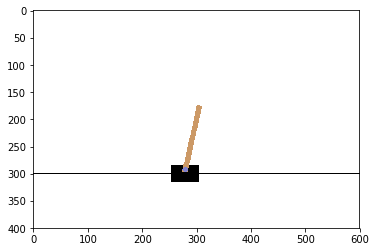

In [133]:
import random
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

import gym
from gym import wrappers

env = gym.make('CartPole-v0')
env = wrappers.Monitor(env, './video') # save animations

N_EPSD=1000
DISP_EPSD=1000 # アニメーション表示は非常に時間がかかる!
T_MAX=200
N_BINS=10

history=np.zeros(N_EPSD)

cart_pos_bins = np.linspace(start=-2.0, stop=2.0, num=N_BINS-1)
pole_ang_bins = np.linspace(start=-1.6, stop=1.6, num=N_BINS-1)
cart_vel_bins = np.linspace(start=-1.8, stop=1.8, num=N_BINS-1)
pole_angvel_bins = np.linspace(start=-2.8, stop=2.8, num=N_BINS-1)

def build_state(features):
    return int("".join(map(lambda feature: str(int(feature)), features)))

def to_bin(value, bins):
    return np.digitize(x=[value], bins=bins)[0]


rl=QLearn(actions=list(range(env.action_space.n)),
                        alpha=0.5, gamma=0.9, epsilon=0.1)

for i_episode in range (N_EPSD):
    obs = env.reset()
    cart_pos, pole_ang, cart_vel, pole_angvel = obs
    state = build_state([to_bin(cart_pos, cart_pos_bins),
                         to_bin(pole_ang, pole_ang_bins),
                         to_bin(cart_vel, cart_vel_bins),
                         to_bin(pole_angvel, pole_angvel_bins)])    
    
    for t in range(T_MAX):
        if i_episode % DISP_EPSD == 0:
            print("Episode={}, Time={}".format(i_episode+1,t+1))
            plt.imshow(env.render(mode='rgb_array'))
            display.clear_output(wait=True)
            display.display(plt.gcf())

        action = rl.chooseAction(state) # act randomly

        obs_new, reward, terminal, info = env.step(action)
        cart_pos, pole_ang, cart_vel, pole_angvel = obs_new
        state_new = build_state([to_bin(cart_pos, cart_pos_bins),
                         to_bin(pole_ang, pole_ang_bins),
                         to_bin(cart_vel, cart_vel_bins),
                         to_bin(pole_angvel, pole_angvel_bins)])    

        rl.learn(state, action, reward, state_new)
        
        if terminal:
            if i_episode % DISP_EPSD == 0:
                plt.imshow(env.render(mode='rgb_array'))
                display.clear_output(wait=True)
                display.display(plt.gcf())

            reward=-20
            rl.learn(state, action, reward, state_new)

            print("Episode {} finished after {} timesteps".format(i_episode+1,t+1))
            history[i_episode]=t+1
            break

        state = state_new

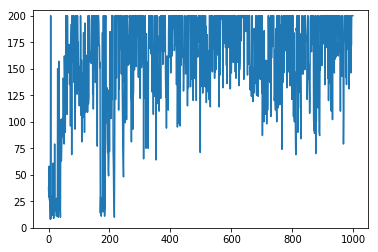

In [129]:
plt.ylim(0,history.max()+5)
plt.plot(history)